In [81]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Step 1: Load the original dataset
# # Replace 'original_dataset.csv' with the path to your actual CSV file
# df1 = pd.read_csv('tweet_emotions.csv')
# df1 = df1.drop(columns=['tweet_id'])

# sentiments_to_drop = ['boredom', 'enthusiasm', 'relief', 'surprise', 'worry']

# df = df1[~df1['sentiment'].isin(sentiments_to_drop)]
# df = df.rename(columns={'sentiment': 'label', 'content': 'text'})


# # Step 2: Check the columns of your CSV (this is optional, but useful for ensuring correct columns)
# print(df.columns)
# print(df['label'].unique())
# # Step 3: Perform an 80:20 split
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Step 4: Save the splits to separate CSV files
# train_df.to_csv('train.csv', index=False)  # Save training data
# test_df.to_csv('test.csv', index=False)    # Save test data

# print("Train and test CSVs created successfully!")


In [82]:
# # # step: 1
!pip3 install pyarrow==14.0.1
!pip3 install -q transformers datasets torch accelerate evaluate

In [83]:
# step: 2
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import torch
import evaluate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report


In [84]:
# Step 3: Define your emotion classes
emotion_labels = ['empty', 'sadness', 'neutral', 'love', 'fun', 'hate', 'happiness', 'anger']
num_labels = len(emotion_labels)

In [85]:
# Step 4: Load the dataset from CSV files
# Assuming your dataset is split into train and test CSVs with 'text' for the tweet and 'label' for the emotion label
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})
train_dataset = dataset['train'].select(range(1000))  # Select first 1000 samples for training
eval_dataset = dataset['test'].select(range(200))  # Select first 200 samples for evaluation


In [86]:
# Step 5: Load the BERT tokenizer
model_name = 'bert-base-cased'  # You can use 'bert-base-uncased' if your data is not case-sensitive
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [87]:
# Step 6: Function to map emotion labels to numeric indices
def map_labels(example):
    # Convert text label to an integer index based on the emotion_labels list
    example['label'] = emotion_labels.index(example['label'])
    return example

# Apply label mapping to train and test datasets
dataset = dataset.map(map_labels)


In [88]:

# Step 7: Function to tokenize the dataset
def tokenize_function(example):
    # Tokenize the 'text' column of the dataset
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)


In [89]:
# Step 8: Remove unnecessary columns after tokenization
# We only need 'input_ids', 'attention_mask', and 'label' for training, so remove 'text'
tokenized_dataset = tokenized_dataset.remove_columns(['text'])


In [90]:

# Step 9: Load the BERT model with a classification head for multi-class classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For Freezing the layers

In [91]:

# # Specify how many layers to freeze (e.g., freeze the first 6 layers)
# num_layers_to_freeze = 6

# # Freeze the specified layers
# for i, layer in enumerate(model.bert.encoder.layer):
#     if i < num_layers_to_freeze:
#         for param in layer.parameters():
#             param.requires_grad = False

# # You can check which layers are frozen
# for i, layer in enumerate(model.bert.encoder.layer):
#     print(f"Layer {i} requires_grad: {[param.requires_grad for param in layer.parameters()]}")

In [92]:
# Step 10: Define training arguments for the Trainer API
training_args = TrainingArguments(
    output_dir="./results",               # Output directory for model checkpoints
    evaluation_strategy="epoch",          # Evaluate after every epoch
    save_strategy="epoch",                # Save model checkpoint after every epoch
    num_train_epochs=3,                   # Number of training epochs
    per_device_train_batch_size=8,       # Training batch size per device (adjust based on your hardware)
    per_device_eval_batch_size=8,        # Evaluation batch size per device
    load_best_model_at_end=True,          # Load the best model at the end of training
    metric_for_best_model="accuracy",     # Use accuracy to select the best model
    logging_dir='./logs',                 # Directory for storing logs
    logging_strategy="epoch",             # Log at the end of each epoch
    report_to="none",                     # Disable reporting to external platforms like TensorBoard
    fp16=True,  # Enable mixed precision

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [93]:
# Step 11: Define a function to compute metrics for evaluation
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    # Unpack predictions and labels from eval_pred
    logits, labels = eval_pred
    # Take the argmax of the logits to get the predicted class
    predictions = np.argmax(logits, axis=-1)
    # Return the computed accuracy
    return accuracy_metric.compute(predictions=predictions, references=labels)


In [94]:
train_dataset = tokenized_dataset['train'].select(range(2000))  # Select first 1000 samples for training
eval_dataset = tokenized_dataset['test'].select(range(1000))  # Select first 200 samples for evaluation

In [95]:
# Step 12: Initialize the Trainer with model, arguments, dataset, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [96]:
# Step 13: Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.632500,1.503996,0.459000
2,1.253900,1.534309,0.454000
3,0.850600,1.686768,0.467000


TrainOutput(global_step=750, training_loss=1.2456709391276042, metrics={'train_runtime': 252.0031, 'train_samples_per_second': 23.809, 'train_steps_per_second': 2.976, 'total_flos': 1578751377408000.0, 'train_loss': 1.2456709391276042, 'epoch': 3.0})

In [97]:
# Step 14: Evaluate the model on the test set
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']}")

Test Accuracy: 0.467


In [98]:
# Step 1: Ensure the model is moved to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device

def predict_emotion(tweet):
    # Tokenize the input tweet
    inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Put the model in evaluation mode
    model.eval()

    # Disable gradient calculation (inference mode)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label (the argmax of the logits)
    predicted_label = torch.argmax(outputs.logits, dim=-1).item()

    # Return the predicted emotion (convert label back to emotion)
    return emotion_labels[predicted_label]

new_tweet = "I am so happy today!"
predicted_emotion = predict_emotion(new_tweet)
print(f"Predicted emotion: {predicted_emotion}")


Predicted emotion: love


In [99]:

# Step 1: Get predictions from the model
predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)  # Get the predicted class labels

# Step 2: Get the true labels
true_labels = eval_dataset['label']
unique_true_labels = np.unique(true_labels)
unique_pred_labels = np.unique(pred_labels)

print(f"Unique true labels: {unique_true_labels}")
print(f"Unique predicted labels: {unique_pred_labels}")
all_labels = list(range(len(emotion_labels)))

# Generate the classification report including all labels
print(classification_report(true_labels, pred_labels, labels=all_labels, target_names=emotion_labels))

Unique true labels: [0 1 2 3 4 5 6 7]
Unique predicted labels: [1 2 3 4 5 6]
              precision    recall  f1-score   support

       empty       0.00      0.00      0.00        36
     sadness       0.46      0.52      0.49       198
     neutral       0.55      0.62      0.58       324
        love       0.58      0.39      0.47       152
         fun       0.14      0.07      0.10        67
        hate       0.30      0.19      0.23        42
   happiness       0.37      0.53      0.43       173
       anger       0.00      0.00      0.00         8

    accuracy                           0.47      1000
   macro avg       0.30      0.29      0.29      1000
weighted avg       0.44      0.47      0.45      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


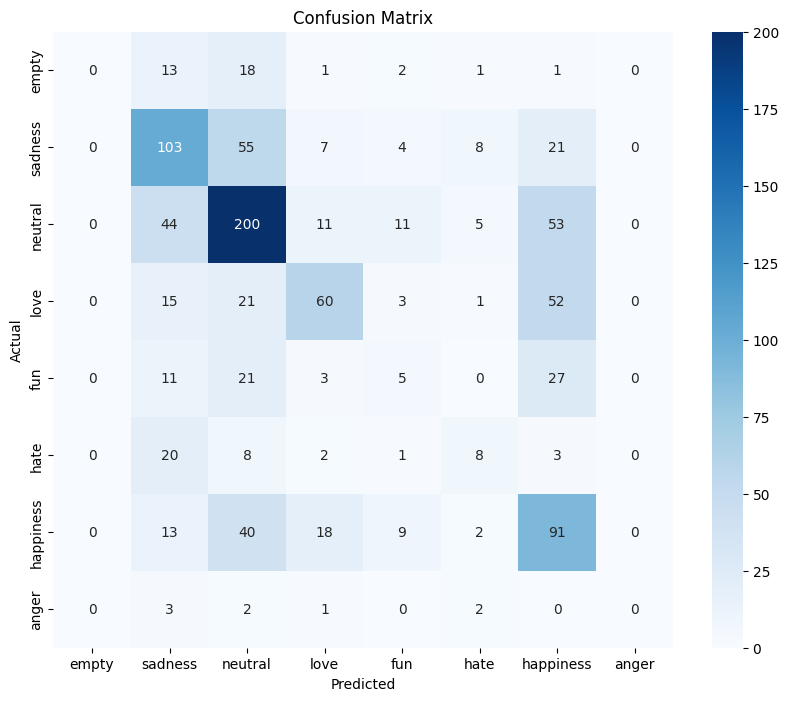

In [100]:


# Step 1: Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [102]:
new_tweet = "Everything seems meaningless right now."
predicted_emotion = predict_emotion(new_tweet)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: sadness


In [103]:
new_tweet = "Playing video games with friends is always so much fun!"
predicted_emotion = predict_emotion(new_tweet)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: happiness


In [104]:
new_tweet = "Today has been one of the best days ever!"
predicted_emotion = predict_emotion(new_tweet)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: happiness


In [107]:
new_tweet = "I went to the store to buy !"
predicted_emotion = predict_emotion(new_tweet)
print(f"Predicted emotion: {predicted_emotion}")

Predicted emotion: neutral
